In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os 

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir']= os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import math
from sklearn import preprocessing
from sklearn.neighbors import BallTree

from matplotlib import pyplot as plt, colors

In [2]:
### Global Constants
MIN_LON = -98.0
MAX_LON = -76.400024
MIN_LAT = 18.12
MAX_LAT = 31.92

#cell size
CELL_SIZE = 1/25

#earth radius in km 
EARTH_RADIUS_KM = 6371

#### GOM Masks

In [3]:
gom_masks = xr.open_dataset('data/gom_masks.nc')
gom_masks

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:      (Latitude: 346, Longitude: 540)
Coordinates:
    MT           object ...
    Date         float64 ...
  * Latitude     (Latitude) float32 18.12 18.16 18.2 18.24 ... 31.84 31.88 31.92
  * Longitude    (Longitude) float32 -98.0 -97.96 -97.92 ... -76.48 -76.44
Data variables:
    depth        (Latitude, Longitude) float32 ...
    landmask     (Latitude, Longitude) int32 ...
    coastalmask  (Latitude, Longitude) int32 ...
    shore        (Latitude, Longitude) int32 ...
    disp_vx      (Latitude, Longitude) float64 ...
    disp_vy      (Latitude, Longitude) float64 ...
    d2s          (Latitude, Longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    title:        HYCOM
    source:       HYCOM archive file
    experiment:   00.0
    history:      archv2ncdf2d

#### Particle Release DataFrame

In [4]:
"""
params:
    idx_mask - mask indexed by (lat, lon)
    lats - list of latitude values
    lons - list of longitude values
    
returns:
    list of lat and lon for the masked values
"""
def get_cells(idx_mask, lats, lons):
    if idx_mask is None:
        return np.array([lats, lons])
    
    cell_lats = lats[idx_mask[0]]
    cell_lons = lons[idx_mask[1]]
    return np.array([cell_lats, cell_lons], dtype = np.float64)

"""
params:
    cells - list of lat and lon values
returns:
    BallTree object
"""
def build_ll_BallTree(cells):
    cells_rad = (np.transpose(cells) * np.pi) / 180

    return BallTree(cells_rad, leaf_size = 2, metric = 'haversine') 

def query_ll_BallTree(tree, cells):
    cells_rad  = (np.transpose(cells) * np.pi) / 180 

    dist, ind = tree.query(cells_rad, k = 1)
    
    return dist.T[0]*EARTH_RADIUS_KM, ind.T[0]

In [5]:
# CREATE COAST CELL TREE
idx_coast_mask = np.where(gom_masks.coastalmask == 1)
coast_cells = get_cells(idx_mask = idx_coast_mask, 
                            lats = gom_masks.Latitude.values,
                            lons = gom_masks.Longitude.values)
coast_cell_tree = build_ll_BallTree(coast_cells)

#### River Input

In [6]:
# PROCESS RIVER DATA
def preprocess_river_data(file_loc):
    rivers = pd.read_csv(file_loc).dropna(subset = 'i_mid')
    rivers = rivers[(rivers['X'] >= MIN_LON) & (rivers['X'] <= MAX_LON) & (rivers['Y'] >= MIN_LAT) & (rivers['Y'] <= MAX_LAT)]
    rivers['i_mid_kg']  = (rivers['i_mid'] * 1000)
    rivers['i_mid_kg_mon'] = rivers['i_mid_kg'] / 12
    rivers_considered = rivers[rivers['i_mid_kg_mon'] > 0.5]
    return rivers_considered

file_loc = '../gom_tests/PlasticRiverInputs.csv'
rivers_considered = preprocess_river_data(file_loc)
total_mon_river_input = np.sum(rivers_considered.i_mid_kg_mon)

# FIND CLOSEST CELL TO RIVER LOCATIONS
river_cells = get_cells(idx_mask = None, lats = rivers_considered.Y.values, lons = rivers_considered.X.values)
_, river_ind = query_ll_BallTree(tree = coast_cell_tree, cells = river_cells)

# ADD RIVER INPUT TO COSTAL CELL DATAFRAME
d = {'river_ind': river_ind, 'river_kg': rivers_considered['i_mid_kg'].values}

df_all_rivers = pd.DataFrame(data=d)
counts_rivers  = df_all_rivers.river_ind.value_counts(sort = False)
df_all_rivers = df_all_rivers.groupby('river_ind').sum()

# ADD RIVER INPUT TO NETCDF
final_river_inds = df_all_rivers.index.values
final_river_kg = df_all_rivers['river_kg'].values

river_input = np.zeros((346, 540))
idx_river_lats = idx_coast_mask[0][final_river_inds]
idx_river_lons = idx_coast_mask[1][final_river_inds]
river_input[idx_river_lats, idx_river_lons] += final_river_kg
assert(int(np.sum(river_input)) == int(np.sum(rivers_considered['i_mid_kg'].values))) # check the total river kg count

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


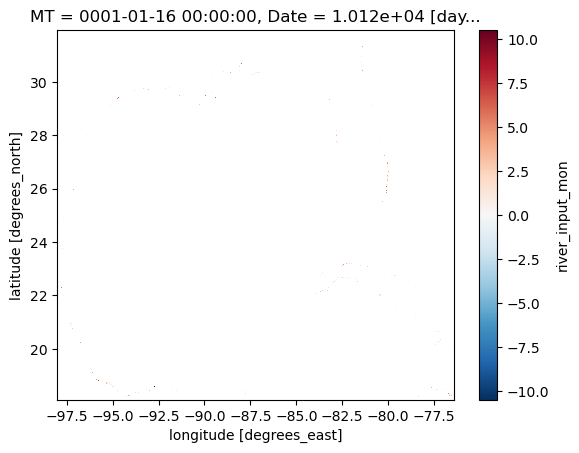

In [7]:
river_input_mon = river_input / 12.0
gom_masks = gom_masks.assign(river_input_mon = (('Latitude', 'Longitude'), river_input_mon))
np.log(gom_masks.river_input_mon).plot()

#### Land Input

In [8]:
# PREPROCESS LAND DATA
mpw_ds = xr.open_zarr('../gom_tests/mpw_output')
mpw_ds = mpw_ds.rename({'X': 'lon','Y': 'lat'})
mpw_ds = mpw_ds.isel(lat=slice(None, None, -1))

# FIND CLOSEST CELL TO LAND LOCATIONS
land_cells_idx = np.where(mpw_ds.mpw_output >= 1.0)
land_cells = get_cells(idx_mask = land_cells_idx, 
                            lats = mpw_ds.lat.values,
                            lons = mpw_ds.lon.values)

land_mpw = mpw_ds.mpw_output.values[land_cells_idx]
land_dist, land_ind = query_ll_BallTree(tree = coast_cell_tree, cells = land_cells)

# FIND ALL LOCATIONS WITHIN 50km OF THE COAST
land_dist_to_coast = 50.0
land_cells_within_radius = np.where(land_dist < land_dist_to_coast)[0]
coastal_ind_within_radius = land_ind[land_cells_within_radius]
land_mpw_to_coast = land_mpw[land_cells_within_radius]

# ADD LAND INPUT TO COASTAL CELL DATAFRAME
df_all_land = pd.DataFrame(data={'coastal_ind_within_radius': coastal_ind_within_radius, 'land_mpw_to_coast': land_mpw_to_coast})
counts_land  = df_all_land.coastal_ind_within_radius.value_counts(sort = False)
df_all_land = df_all_land.groupby('coastal_ind_within_radius').sum()

# ADD LAND INPUT TO NETCDF
final_land_inds = df_all_land.index.values
final_land_kg = df_all_land['land_mpw_to_coast'].values

land_input = np.zeros((346, 540))
idx_land_lats = idx_coast_mask[0][final_land_inds]
idx_land_lons =  idx_coast_mask[1][final_land_inds]
land_input[idx_land_lats, idx_land_lons] += final_land_kg
assert(int(np.sum(land_input)) == int(np.sum(land_mpw_to_coast))) # sanity check

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


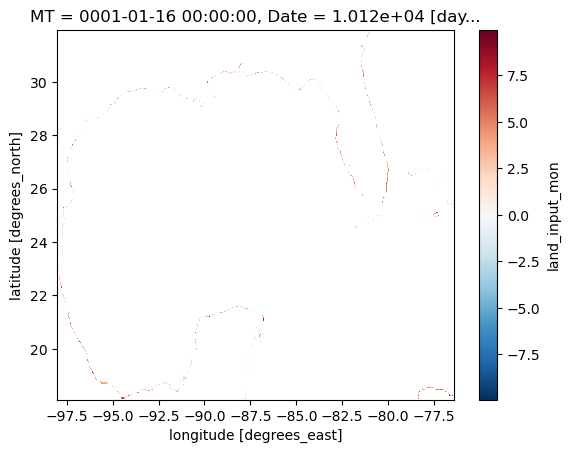

In [9]:
land_input_mon = land_input * 0.15 / 12.0
gom_masks = gom_masks.assign(land_input_mon = (('Latitude', 'Longitude'), land_input_mon))
np.log(gom_masks.land_input_mon).plot()

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


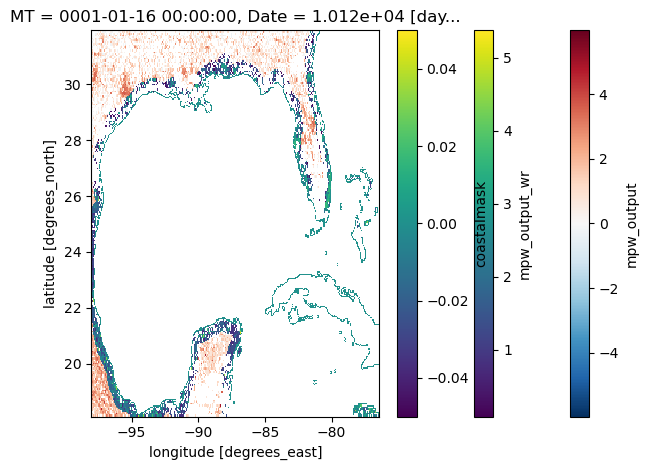

In [10]:
# Display land contribution to coastal cells
mpw_within_50km = np.zeros( (mpw_ds.dims['lat'], mpw_ds.dims['lon']) )
mpw_within_50km_lat = land_cells_idx[0][land_cells_within_radius]
mpw_within_50km_lon = land_cells_idx[1][land_cells_within_radius]
mpw_within_50km[mpw_within_50km_lat, mpw_within_50km_lon] = mpw_ds.mpw_output.values[mpw_within_50km_lat,mpw_within_50km_lon]

mpw_ds = mpw_ds.assign(mpw_output_wr = (('lat', 'lon'), mpw_within_50km))

np.log10(mpw_ds.mpw_output).plot()
np.log10(mpw_ds.mpw_output_wr).plot()
np.log10(gom_masks.coastalmask).plot()
plt.tight_layout()

#### Fishing Input

In [11]:
# CREATE OCEAN CELL TREE
idx_ocean_mask = np.where(gom_masks.landmask == 0)
ocean_cells = get_cells(idx_mask = idx_ocean_mask, 
                            lats = gom_masks.Latitude.values,
                            lons = gom_masks.Longitude.values)
ocean_cell_tree = build_ll_BallTree(ocean_cells)

In [13]:
# Calculate Fishing Mass Contribution 
river_mon_total, land_mon_total = np.sum(gom_masks.river_input_mon).values, np.sum(gom_masks.land_input_mon).values
input_data_total = river_mon_total + land_mon_total
rp = 0.121
cp = 0.598
fp = 0.179 + 0.089 + 0.013
fishing_total = (input_data_total ) * (fp / (1 - fp))
print(f'land total: {land_mon_total}, river total: {river_mon_total}, fishing total {fishing_total}, total: {fishing_total + input_data_total}')
# land total: 84078.20223895162, river total: 46136.00716666667, fishing total 50890.39338383691, total: 181104.6027894552

# PREPROCESS FISHING DATA
fishing_ds = xr.open_zarr('../gom_tests/fishing_effort.tif')
fishing_ds = fishing_ds.rename({'X': 'lon','Y': 'lat'})
fishing_ds = fishing_ds.isel(lat=slice(None, None, -1))

# CREATE FISHING DATAFRAME
fishing_cell_idx = np.where(fishing_ds.fishing_effort > 1.0)
fishing_cells = get_cells(idx_mask = fishing_cell_idx, 
                            lats = fishing_ds.lat.values,
                            lons = fishing_ds.lon.values)
fishing_effort = fishing_ds.fishing_effort.values[fishing_cell_idx]

fishing_cells_data = np.array([fishing_cells[0], fishing_cells[1], fishing_effort])
fishing_cell_df = pd.DataFrame(fishing_cells_data.T, columns=['lats', 'lons', 'fishing_effort'])

fishing_cell_df['prop_total'] = fishing_cell_df['fishing_effort'] / np.sum(fishing_cell_df['fishing_effort'])
fishing_cell_df['fishing_kg'] = fishing_cell_df['prop_total'] * fishing_total * 12.0

# FIND CLOSEST OCEAN CELL TO FISHING LOCATIONS
_, fishing_ind = query_ll_BallTree(tree = ocean_cell_tree, cells = fishing_cells)

f = {'fishing_ind': fishing_ind, 'fishing_kg': fishing_cell_df['fishing_kg'].values}
df_all_fishing = pd.DataFrame(data=f)
counts_fishing = df_all_fishing.fishing_ind.value_counts(sort = False)
df_all_fishing = df_all_fishing.groupby('fishing_ind').sum()

# ADD FISHING INPUT TO NETCDF
final_fishing_inds = df_all_fishing.index.values
final_fishing_kg = df_all_fishing['fishing_kg'].values

fishing_input = np.zeros((346, 540))
idx_fishing_lats = idx_ocean_mask[0][final_fishing_inds]
idx_fishing_lons =  idx_ocean_mask[1][final_fishing_inds]
fishing_input[idx_fishing_lats, idx_fishing_lons] += final_fishing_kg
assert(int(np.sum(fishing_input)) == int(np.sum(fishing_cell_df['fishing_kg']))) # sanity check

land total: 84078.2022389516, river total: 46136.00716666667, fishing total 50890.39338383691, total: 181104.6027894552


c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


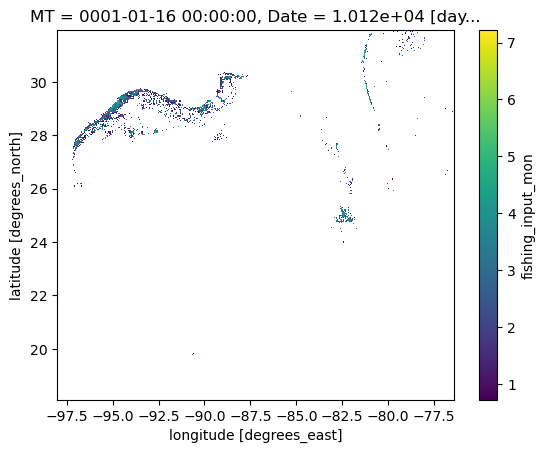

In [14]:
fishing_input_mon =  fishing_input / 12.0
gom_masks = gom_masks.assign(fishing_input_mon = (('Latitude', 'Longitude'), fishing_input_mon))
np.log(gom_masks.fishing_input_mon).plot()

In [17]:
# ASSIGN COASTAL RELEASE MASK
num_coastal_releases = int(gom_masks.coastalmask.sum())
coastal_ids = np.array(list(range(num_coastal_releases)), dtype = int) + 1
coastal_mask_idx = np.where(gom_masks.coastalmask == 1)

coastal_id_mask = np.zeros((346, 540))
coastal_id_mask[coastal_mask_idx[0], coastal_mask_idx[1]] = coastal_ids
gom_masks = gom_masks.assign(coastal_id_mask = (('Latitude', 'Longitude'), coastal_id_mask))

# ASSIGN OCEAN RELEASE MASK
fishing_mask = np.where((gom_masks.coastalmask == 0.0) & (gom_masks.fishing_input_mon > 0.0))
num_ocean_releases = np.shape(fishing_mask)[1]
ocean_ids = coastal_ids[-1] + np.array(list(range(num_ocean_releases)), dtype = int) + 1

ocean_id_mask = np.zeros((346, 540))
ocean_id_mask[fishing_mask[0], fishing_mask[1]] = ocean_ids
gom_masks = gom_masks.assign(ocean_id_mask = (('Latitude', 'Longitude'), ocean_id_mask))

#### Save To NetCDF

In [24]:
gom_masks = gom_masks.drop(['MT', 'Date'])

In [27]:
gom_masks.close()

In [29]:
def download_netcdf_file(ds, file_name):
    try:
        os.remove(file_name)
        print("Done Deleting")
    except OSError:
        pass

    ds.to_netcdf(path = file_name)
    
download_netcdf_file(gom_masks, 'data/gom_masks_w_inputs.nc')